In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn 
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader,Subset
from sklearn.model_selection import KFold
import os
from torchinfo import summary

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class DeepLens(nn.Module):
    def __init__(self,normalized_r2):
        super(DeepLens, self).__init__()
        self.normalized_r2 = normalized_r2
        
    # Step 2: Use another ResNet-18 for vector A
        self.resnet_A = models.resnet18(pretrained=True)
        
#         for param in self.resnet_B.parameters():  # Freeze ResNet-18 parameters
#             param.requires_grad = False
            
        self.features_A = nn.Sequential(*list(self.resnet_A.children())[:-2])
        self.features_A.add_module('flatten', nn.Flatten())
        self.features_A.add_module('dropout', nn.Dropout(p=0.4))  # Adding dropout layer
        self.relu = nn.ReLU(inplace=True)
        self.features_A.add_module('linear', nn.Linear(12800, 22500))
        
    # Step 3: Use another ResNet-18 for vector B
        self.resnet_B = models.resnet18(pretrained=True)
        
#         for param in self.resnet_B.parameters():  # Freeze ResNet-18 parameters
#             param.requires_grad = False
            
        self.features_B = nn.Sequential(*list(self.resnet_B.children())[:-2])
        self.features_B.add_module('flatten', nn.Flatten())
        self.features_B.add_module('dropout', nn.Dropout(p=0.4))  # Adding dropout layer
#         self.relu = nn.ReLU(inplace=True)
        self.features_B.add_module('linear', nn.Linear(12800, 22500))
        
        # Step 5: Neural layer and softmax
        
        self.neural_layer1 = nn.Linear(22500,5625 )
        self.neural_layer2 = nn.Linear(5625, 128)
        self.neural_layer3 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(p=0.4)  # Adding dropout layer

    def forward(self, x):

        # Step 2: Extract features A
    
        features_A = self.features_A(x)
        features_A = self.relu(features_A)
        features_A = features_A.view(features_A.size(0), -1)
        
        # Step 3: Extract features B
    
        features_B = self.features_B(x)
        features_B = self.relu(features_B)
        features_B = features_B.view(features_B.size(0), -1)
        
        # Step 4: Physics equation C = I - B * (distance from center of image) (treated as constant)
        C = features_A - features_B * (self.normalized_r2)
        
        # Step 5: Neural layer and softmax
        output = self.neural_layer1(C)
        output = self.relu(output)
        output = self.dropout(output)
        
        output = self.neural_layer2(output)
        output = self.relu(output)
        output = self.dropout(output) # Applying dropout
        
        output = self.neural_layer3(output)
        
        return output

In [6]:
torch.cuda.empty_cache()

In [7]:
grid_size = 150

# Initialize an empty tensor to store distances
r2 = torch.zeros(grid_size * grid_size)

# Compute distances for each pixel(SIS)
for i in range(grid_size):
    for j in range(grid_size):
        r2[grid_size * i + j] = ((74.5 - i) ** 2 + (74.5 - j) ** 2)

# Verify the size of dis
print("Size of dis tensor:", r2.size())

# Find the maximum value in the r2 tensor
max_r2 = r2.max()
normalized_r2 = r2/max_r2

# Move r2 tensor to CUDA if available
normalized_r2 = normalized_r2.cuda()

Size of dis tensor: torch.Size([22500])


In [8]:
encoder = DeepLens(normalized_r2).to(device)
# summary(encoder,(3,150,150))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


In [9]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [10]:
train_path = '/kaggle/input/gsoc-pinn1/new_dataset_PINN/train'

In [11]:
class_folders = torchvision.datasets.ImageFolder(train_path,transform=transformer)

In [12]:
from torch.optim.lr_scheduler import StepLR
optimizer = torch.optim.SGD(encoder.parameters(), lr=0.01, weight_decay=0.0001)
# Define the scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
num_epochs = 3
num_folds = 10
best_accuracy = 0.0
loss_fn = nn.CrossEntropyLoss()
# Initialize KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(class_folders)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    dataset_train = Subset(class_folders, train_index)
    dataset_valid = Subset(class_folders, val_index)

    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=64, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset_valid, batch_size=32, shuffle=True
    )
    
    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        encoder.train()
        
        train_accuracy = 0.0
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = encoder(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            train_accuracy += int(torch.sum(prediction == labels.data))
        
        train_accuracy = train_accuracy / len(train_index)
        train_loss = train_loss / len(train_index)
        
        # Validation loop
        encoder.eval()
        
        val_accuracy = 0.0
        val_loss = 0.0
        
        for i, (images, labels) in enumerate(val_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            outputs = encoder(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()* images.size(0)  # Accumulate the loss
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int(torch.sum(prediction == labels.data))
            
        # Compute average loss and accuracy
        val_loss /= len(val_index)
        val_accuracy = val_accuracy / len(val_index)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, Val Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")
        
        # Save the best model
        if val_accuracy > best_accuracy:
            torch.save(encoder.state_dict(), 'best_model.pth')
            best_accuracy = val_accuracy
            
print(f"Best Validation Accuracy: {best_accuracy}")

Fold 1/10
Epoch [1/3], Train Loss: 1.099, Train Accuracy: 0.344, Val Loss: 1.094, Validation Accuracy: 0.367
Epoch [2/3], Train Loss: 1.075, Train Accuracy: 0.396, Val Loss: 1.102, Validation Accuracy: 0.374
Epoch [3/3], Train Loss: 0.942, Train Accuracy: 0.515, Val Loss: 0.897, Validation Accuracy: 0.564
Fold 2/10
Epoch [1/3], Train Loss: 0.758, Train Accuracy: 0.652, Val Loss: 0.732, Validation Accuracy: 0.674
Epoch [2/3], Train Loss: 0.623, Train Accuracy: 0.735, Val Loss: 0.749, Validation Accuracy: 0.702
Epoch [3/3], Train Loss: 0.548, Train Accuracy: 0.771, Val Loss: 0.537, Validation Accuracy: 0.779
Fold 3/10
Epoch [1/3], Train Loss: 0.489, Train Accuracy: 0.803, Val Loss: 0.505, Validation Accuracy: 0.791
Epoch [2/3], Train Loss: 0.449, Train Accuracy: 0.820, Val Loss: 0.641, Validation Accuracy: 0.767
Epoch [3/3], Train Loss: 0.424, Train Accuracy: 0.831, Val Loss: 0.437, Validation Accuracy: 0.818
Fold 4/10
Epoch [1/3], Train Loss: 0.401, Train Accuracy: 0.842, Val Loss: 0.45

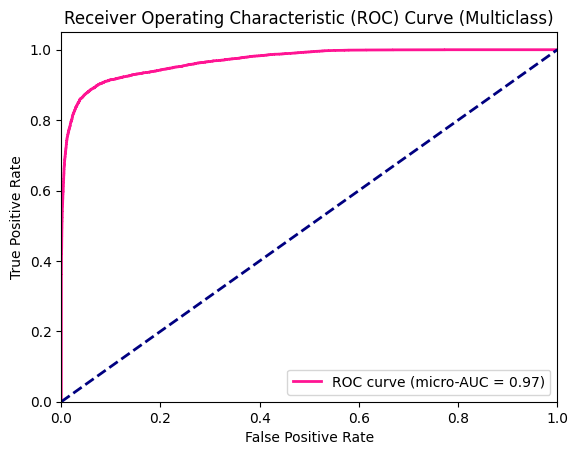

In [16]:
test_path='/kaggle/input/gsoc-pinn1/new_dataset_PINN/val'
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_score_list = []
y_true_list = []

# Evaluate model
encoder.eval()
for images, labels in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

    with torch.no_grad():
        y_score_batch = encoder(images)
    
    y_score_list.append(y_score_batch.cpu().numpy())
    y_true_list.append(labels.cpu().numpy())

y_score = np.vstack(y_score_list)
y_true = np.hstack(y_true_list)

# Binarize the ground truth labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label=f'ROC curve (micro-AUC = {roc_auc["micro"]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Due to large size of weigths
import zipfile

with zipfile.ZipFile("model_weights.zip", "w", zipfile.ZIP_DEFLATED) as zf:
    zf.write("model_weights.pth")